In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.test.is_gpu_available()

2023-03-23 01:47:40.397651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 01:47:42.371313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/pkgs/cudnn-8.1.0.77-h90431f1_0/lib/:/opt/conda/pkgs/cudatoolkit-11.2.2-he111cf0_8/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 01:47:42.371453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_L

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-03-23 01:47:44.856757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 01:47:46.136596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 10405 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:86:00.0, compute capability: 6.1


True

(16781312, 21)
(16781312,)
(13425049, 21)
(13425049,)
(3356263, 21)
(3356263,)
(1638, 8192, 21)
(1638, 8192)
(409, 8192, 21)
(409, 8192)


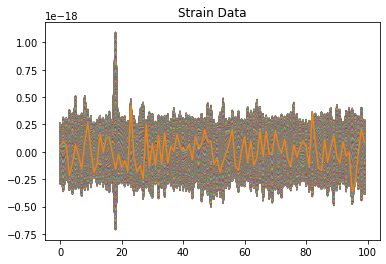

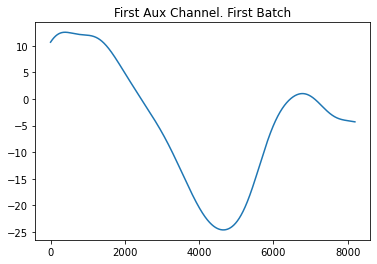

Finding pass-band frequencies via Cross Spectral Density Analysis


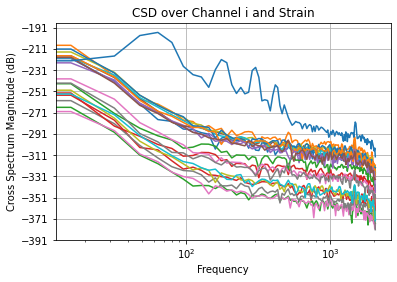

Finding pass-band frequencies via Cross Spectral Density Analysis


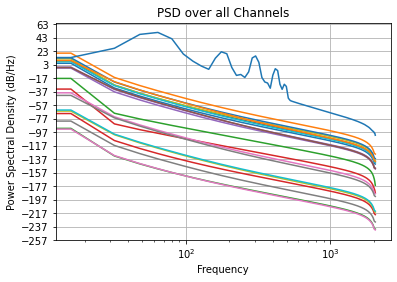

Building Butterworth Filter


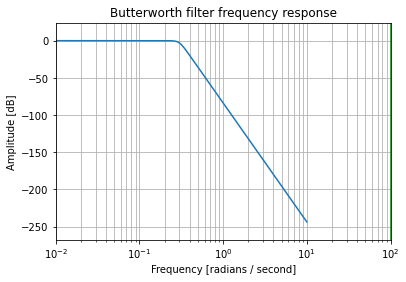

Butterworth filter built
Applying Butterworth to data
Train Witness shape: (1638, 8192, 21)
Test Witness shape: (409, 8192, 21)


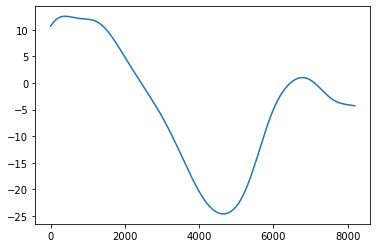

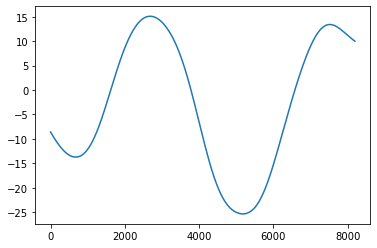

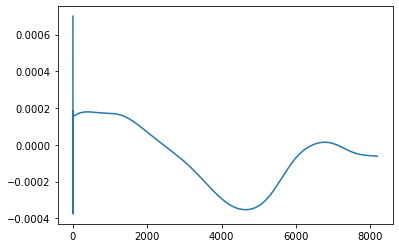

Butterworth filter applied to Train data


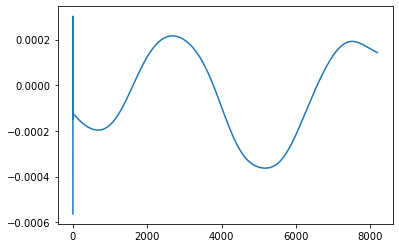

Butterworth filter applied to Test data
Normalization in progress


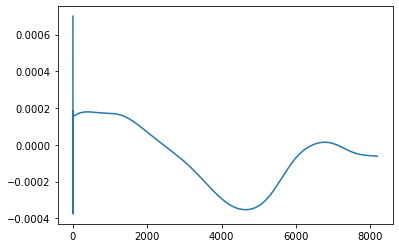

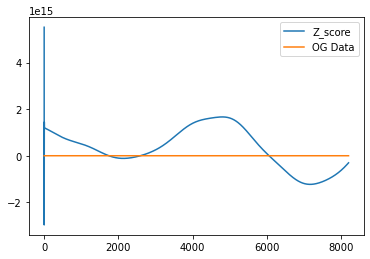

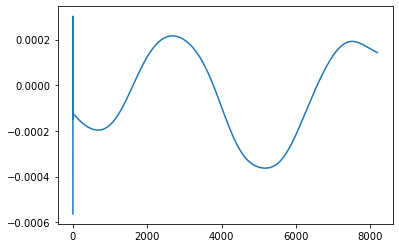

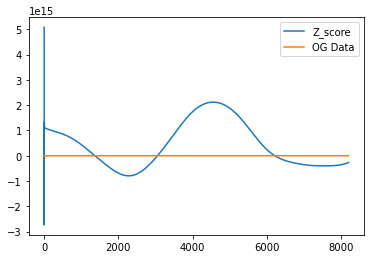

CNN Data Ready, Import witness_data
(1638, 8192, 21)
Normalization Complete
Applying Welch's Method
Welch's Method Complete
(1638, 8192) (409, 8192)
(1638, 8192, 21) (1638, 8192) (409, 8192, 21) (409, 8192)


In [2]:
#Import data from preprocessing file
from ipynb.fs.full.data_preprocessing import send_freq_data, send_time_data
import matplotlib.pyplot as plt
import numpy as np

freq_data_train, fstrain_data_train, freq_data_test, fstrain_data_test = send_freq_data()
witness_data_train, tstrain_data_train, witness_data_test, tstrain_data_test = send_time_data()

print(witness_data_train.shape, tstrain_data_train.shape,
      witness_data_test.shape, tstrain_data_test.shape)

# DeepClean

In [3]:
model = keras.models.Sequential(name="deepclean")
#Convolution Layers
model.add(layers.Conv1D(filters=21, kernel_size=7, strides=1, padding="same", activation="tanh",\
                        input_shape=(witness_data_train.shape[1], witness_data_train.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=8, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=16, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())

#Deconvolution Layers
model.add(layers.Conv1DTranspose(filters=32, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=16, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=8, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=21, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=1, kernel_size=7, padding="same", name = "output"))

model.summary()

#non-trainable parameters come from the BatchNormalization

2023-03-23 01:49:43.299649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:86:00.0, compute capability: 6.1


Model: "deepclean"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8192, 21)          3108      
                                                                 
 batch_normalization (BatchN  (None, 8192, 21)         84        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 4096, 8)           1184      
                                                                 
 batch_normalization_1 (Batc  (None, 4096, 8)          32        
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 2048, 16)          912       
                                                                 
 batch_normalization_2 (Batc  (None, 2048, 16)         64

In [4]:
import numpy as np

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.8)

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

results = model.fit(
    witness_data_train,
    tstrain_data_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                keras.callbacks.EarlyStopping(patience=10, verbose=1),
    ],
)

2023-03-23 01:49:44.103515: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1014300672 exceeds 10% of free system memory.
2023-03-23 01:49:45.477110: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1014300672 exceeds 10% of free system memory.


Epoch 1/10


2023-03-23 01:49:52.008533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-23 01:49:52.426023: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-23 01:49:53.063226: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562361310ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-23 01:49:53.063286: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce GTX 1080 Ti, Compute Capability 6.1
2023-03-23 01:49:53.072311: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

 2/47 [>.............................] - ETA: 3s - loss: 2.4175  

2023-03-23 01:49:58.457049: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


47/47 [==============================] - 17s 99ms/step - loss: 1.1006 - val_loss: 1.0428 - lr: 9.0245e-04
Epoch 2/10
47/47 [==============================] - 3s 54ms/step - loss: 0.9974 - val_loss: 1.0436 - lr: 8.1259e-04
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.9963 - val_loss: 1.0464 - lr: 7.3169e-04
Epoch 4/10
47/47 [==============================] - 2s 46ms/step - loss: 0.9961 - val_loss: 1.0526 - lr: 6.5884e-04
Epoch 5/10
47/47 [==============================] - 2s 46ms/step - loss: 0.9959 - val_loss: 1.0570 - lr: 5.9324e-04
Epoch 6/10
47/47 [==============================] - ETA: 0s - loss: 0.9958
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002670870744623244.
47/47 [==============================] - 2s 43ms/step - loss: 0.9958 - val_loss: 1.0563 - lr: 5.3417e-04
Epoch 7/10
47/47 [==============================] - 2s 48ms/step - loss: 0.9958 - val_loss: 1.0533 - lr: 4.8099e-04
Epoch 8/10
47/47 [==============================] - 2s 41m

<Figure size 1440x720 with 0 Axes>

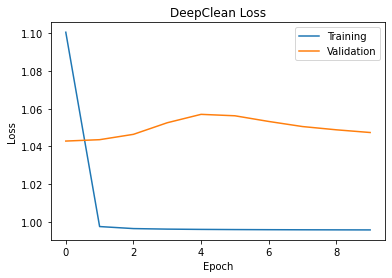

<Figure size 1440x720 with 0 Axes>

In [5]:
#History plot from plotting.py
from matplotlib import figure
import matplotlib.pyplot as plt

loss = results.history["loss"]
val_loss = results.history["val_loss"]
n_epochs = len(loss)


plt.plot(np.arange(n_epochs), loss, label="Training")
plt.plot(np.arange(n_epochs), val_loss, label="Validation")
plt.legend()
plt.title("DeepClean Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.ylim(0,0.01)
plt.figure(figsize=(20,10))

In [6]:
#model.predict() to produce predicted noise
noise_predict = model.predict(witness_data_test)
noise_predict = np.squeeze(noise_predict)

#reshape so strain_test and predicted 
#noise are both 2d
print(noise_predict.shape)

13/13 [==============================] - 1s 16ms/step
(409, 8192)


In [7]:
#API Call to send to Postprocessing, WIP
def send_predicted_noise():
    """
    noise_predict = predicted noise from model.predict()
    must be postprocessed before subtracting from 
    time_strain data
    
    time_strain_data = original strain, subtract 
    noise_predict from it once its postprocessed to 
    get clean_data
    """
    return noise_predict, tstrain_data_test

# WIP

Tasks:

Modify parameters of interest and measure:
Training time
Validation time
Training loss
Validation loss